In [2]:
import os 
import pandas as pd 
import shutil
import numpy as np
import pickle
from xgboost.sklearn import XGBRegressor
from scipy.stats import norm
import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter


In [3]:
def regional_closs(percentage_peak_strength, sa):
    '''
    This function is developed for compute objective function corresponding to single set of value
    '''
    SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}

    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = percentage_peak_strength[i-1]
        temp['Zpeakstrength'] = percentage_peak_strength[i-1]

        retrof_ratio[i] = pd.concat([temp, retrof_upper_limit]).min(level=0)
        prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'].copy(), retrof_ratio[i]['Zpeakstrength'].copy()

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    closs, _ = compute_closs(sampled_building_info, 
    building_closs = building_loss, 
    building_dsm = retrof_ds_median, 
    design_sa = pd.DataFrame(data = sampled_building_info['SMS']), 
    Sa_map = sa, 
    IM_bin = SMS_bin)
    
    return closs

def compute_closs(sampled_building_info, building_closs, building_dsm, design_sa, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    IM_bin: different retrofit strength is applied to different intensity bins
    '''

    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(total_loss, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all intensity bins
    for k in range(8):
        # loop over all shake maps
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1], how = 'left')
            ds_prob_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map.astype('float64')), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    regional_collapse_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum().sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return regional_collapse_loss, individual_loss


def ordinance_building_loss(sampled_building_info, building_closs, building_dsm, design_sa, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(total_loss, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all shake maps
    for k in range(len(IM_bin)-1):
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1], how = 'left')
            ds_prob_map.loc[(design_sa.iloc[:,0] < IM_bin[k+1]) & (design_sa.iloc[:,0] >= IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map.astype('float64')), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    regional_collapse_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum().sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return regional_collapse_loss, individual_loss

def existing_closs(sampled_building_info, building_closs, building_dsm, Sa_map):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_loss = buildings.merge(building_loss, how = 'left')

    # Building damage state median at each location 
    building_ds_median = buildings.merge(building_dsm, how = 'left')

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))
    # Loop over all shake maps
    for j in range(Sa_map.shape[1]):
        ds_prob_map.iloc[:,j] = norm.cdf(np.log(Sa_map.iloc[:,j]), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_loss = np.multiply(collapse_prob,site_loss.iloc[:,1]).sum().sum()
    individual_loss =  sampled_building_info[['Latitude', 'Longitude']]
    individual_loss['Loss'] = np.multiply(collapse_prob,site_loss.iloc[:,1]).values
    return portfolio_loss, individual_loss

In [4]:
# Sample unknown buildings 
def samplecase(OriginalData):
    InventoryData = OriginalData
    InventoryData = InventoryData.drop(columns = ['SMS'])
    for i in range(InventoryData.shape[0]):
        # Randomly assign number of stories
        if np.isnan(InventoryData.iloc[i,2]):
            InventoryData.iloc[i,2] = np.random.choice(np.arange(2, 4), p=[0.759, 0.241])
            
        # Randomly assign floor type          
        if pd.isnull(InventoryData.iloc[i,3]):
            InventoryData.iloc[i,3] = np.random.choice(np.arange(1, 5), p=[0.159, 0.011, 0.458, 0.372])
            
    
    
    InventoryData.loc[InventoryData['Story'] == 2,'Story'] = "2"
    InventoryData.loc[InventoryData['Story'] == 3,'Story'] = "3"
    
    InventoryData.loc[InventoryData['Type'] == 1,'Type'] = 'FWL1'
    InventoryData.loc[InventoryData['Type'] == 2,'Type'] = 'FWL2'
    InventoryData.loc[InventoryData['Type'] == 3,'Type'] = 'FWL3'
    InventoryData.loc[InventoryData['Type'] == 4,'Type'] = 'FWL4'
    
    InventoryData.loc[InventoryData['Type'] == 'FWL1','Type'] = 'L1'
    InventoryData.loc[InventoryData['Type'] == 'FWL2','Type'] = 'L2'
    InventoryData.loc[InventoryData['Type'] == 'FWL3','Type'] = 'L3'
    InventoryData.loc[InventoryData['Type'] == 'FWL4','Type'] = 'L4'
    
#     Randomly assign material type 
    mat = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Material'] = mat
    
    InventoryData.loc[InventoryData['Material'] == 1,'Material'] = 'GWB'
    InventoryData.loc[InventoryData['Material'] == 2,'Material'] = 'HWS'
    
#     Randomly assign dimension 
    dim = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Dimension'] = dim
    
#     Assign floor type
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X30'
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 1),'Dimension'] = '50X30'
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 2),'Dimension'] = '80X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 50*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 50*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 80*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 80*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3

    InventoryData['Index'] = InventoryData['Type'] + '-' + InventoryData['Story'] + 'S-' + InventoryData['Dimension'].astype('str') + '-' + InventoryData['Material']
    
    #     Randomly assign repair cost
    InventoryData['Num_Units'] = (np.round(InventoryData['Area'].values/1000)).astype(int)
    Median_Cost = np.interp(InventoryData['Num_Units'],[4,30],[6250,4000])
    
    InventoryData['RepairCost'] = np.random.normal(Median_Cost,400)*InventoryData['Num_Units']
    InventoryData['SMS'] = OriginalData['SMS']
    return InventoryData

In [5]:
os.chdir(r'C:\Users\User\Desktop\FinalFinalOptimization\XGBoostPipline\Models')
retrof_complete_ratio = pickle.load(open('Retrof_Complete_Ratio.pkl','rb'))

os.chdir(r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios')
# Read original building info
OriginalBuildingInfo = pd.read_csv('LA Inventory.csv')

# Random assign unknown buildings
sampled_building_info = samplecase(OriginalBuildingInfo)

# Optimize for the M7.1 senario
sa_simulated = pd.read_csv('DBEResults/Sa_simulated_real.csv', header = None)

# Read existing building damage state
existing_ds = pd.read_csv('building_ds.csv')

# Read minnimum strength retrofit
min_strength_retrofit_indicator = pd.read_csv('min_strength_retrofit.csv')

# Read existing building properties and pushover 
existing_prop = pd.read_csv('existing_property.csv')

# Read building losses
total_loss = pd.read_csv('complete_loss.csv')

# Use complete loss as criteria: complete loss = building collapse loss + fatality loss ($2 million per fatality)
building_loss = pd.read_csv('complete_loss.csv') 

# Read retrofit upper limit, which corresponding to NON SWOF building peak strength
retrof_upper_limit = pd.read_csv('UpperLimit.csv')

# Read missing strength
missing_strength = pd.read_csv('building_miss_strength.csv')

# Read existing building damage state medians
existing_ds = pd.read_csv('building_ds.csv')

# Puente Hill
sa_puentehill = pd.read_csv('PuenteHillResults\Sa_simulated_real.csv', header=None)

# Existing pushover peak strength
peak_strength = pd.DataFrame()
peak_strength['Index'] = existing_prop['Index']
peak_strength['Xpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Xpeakstrength'])
peak_strength['Zpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Zpeakstrength'])

[18:58:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Individual Event Assessment 

In [22]:
all_scenario_results = pd.read_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios\Evaluation_results.csv', index_col=0)
event_data = pd.read_csv(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\event_info.csv', index_col=0)
merged_event_info = pd.concat([all_scenario_results, event_data], axis = 1)
merged_event_info = merged_event_info.sort_values(by = 'magnitude')

In [82]:
with open(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\src_rup_metadata.txt', 'r') as f:
    event = f.read()
event = event.split('\n')

In [43]:
event_data.iloc[5861,:]

annual_rate           0.000007
magnitude             6.350000
return period    141572.573995
Name: 5861, dtype: float64

In [59]:
event_data.iloc[6181,:]

annual_rate           0.000009
magnitude             6.750000
return period    116145.859920
Name: 6181, dtype: float64

In [60]:
annual_rate = pd.read_csv(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\RateofExceedance.csv',header=None)
return_period = [int(1/i) for i in annual_rate.iloc[:,0].values]
idx_11 = 5862 # 55034 year 
idx_201 = 6182 # 936482 year 

event_11 = pd.read_csv(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Event%i\Building Site Map.csv'%(idx_11) , header=None)
event_201 = pd.read_csv(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Event%i\Building Site Map.csv'%(idx_201) , header=None)

print(event_11.median(axis = 1).max(), event_11.median(axis = 1).min())
print(event_201.median(axis = 1).max(), event_201.median(axis = 1).min())


0.1212595 0.035640875
0.829905 0.12638749999999999


In [79]:
pd.concat([sampled_building_info[['Latitude', 'Longitude']], event_201.median(axis = 1)], axis = 1).to_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios\LossMap\Event_6182_sa.csv')

In [7]:
# Read the results from Hoffman 
ResultsDirectory = r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios\Results'
W = [0, 100000, 200000, 300000, 400000, 500000, 800000, 1000000, 1500000, 2000000, 2500000, 5000000, 10000000]
sensitivity_results = {}

for i in range(len(W)):
    os.chdir(os.path.join(ResultsDirectory, '%ithWeight'%i))
    sensitivity_results[W[i]] = pd.DataFrame(columns=['a', 'b', 'c', 'd', 'e', 'f', 'g'])
    files = os.listdir('.')
    for f in files:
        sensitivity_results[W[i]] = sensitivity_results[W[i]].append(pd.read_csv(f, index_col=0))

s = time.time()
im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
algorithm_best = sensitivity_results[300000].median(axis = 0).values
SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
retrof_ratio = {}
prop = {}
retrof_ds_ratio = {}
retrof_ds_median = {}
percentage_peak_strength = algorithm_best

for i in range(1,9):
    temp = pd.DataFrame() 
    temp['Index'] = existing_prop['Index']
    temp['Xpeakstrength'] = percentage_peak_strength[i-1]
    temp['Zpeakstrength'] = percentage_peak_strength[i-1]

    retrof_ratio[i] = pd.concat([temp, retrof_upper_limit]).min(level=0)
    prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
    prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'].copy(), retrof_ratio[i]['Zpeakstrength'].copy()

    retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
    retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
    # Compute retrofitted buildings damage state medians 
    retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
    retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

ordinance_dsm_df = pd.read_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\OrdinancePerformance\CollapseMedian.csv')
ordinance_dsm = {}

for i in range(1, ordinance_dsm_df.shape[1]):
    ordinance_dsm[i] = ordinance_dsm_df[['Index','%i'%(i-1)]]

Algorithm_closs_11, Algorithm_closs_individual_11 = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), event_11, SMS_bin)
Algorithm_closs_201, Algorithm_closs_individual_201 = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), event_201, SMS_bin)
Algorithm_closs_ph, Algorithm_closs_individual_ph = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), sa_puentehill, SMS_bin)


Ordinance_closs_11, Ordinance_closs_individual_11 = ordinance_building_loss(sampled_building_info, building_loss, ordinance_dsm, pd.DataFrame(data = sampled_building_info['SMS']), event_11, SMS_bin)
Ordinance_closs_201, Ordinance_closs_individual_201 = ordinance_building_loss(sampled_building_info, building_loss, ordinance_dsm, pd.DataFrame(data = sampled_building_info['SMS']), event_201, SMS_bin)
Ordinance_closs_ph, Ordinance_closs_individual_ph = ordinance_building_loss(sampled_building_info, building_loss, ordinance_dsm, pd.DataFrame(data = sampled_building_info['SMS']), sa_puentehill, SMS_bin)


Existing_closs_11, Existing_closs_individual_11 = existing_closs(sampled_building_info, building_loss, existing_ds, event_11)
Existing_closs_201, Existing_closs_individual_201 = existing_closs(sampled_building_info, building_loss, existing_ds, event_201)
Existing_closs_ph, Existing_closs_individual_ph = existing_closs(sampled_building_info, building_loss, existing_ds, sa_puentehill)


NameError: name 'event_11' is not defined

In [132]:
(results_11['Algorithm Loss']).mean()

0.0008119195524575823

In [126]:
(results_201['Ordinance Loss']>0.10).sum()

3199

In [128]:
(results_201['Existing Loss']>0.40).sum()

302

In [77]:
# 20000 year event results
results_201 = Algorithm_closs_individual_201.copy()
results_201 = results_201.rename(columns={'Loss':'Algorithm Loss'})
results_201['Algorithm Loss'] = np.divide(results_201['Algorithm Loss'].values, sampled_building_info['Area'].values * 200)
results_201['Ordinance Loss'] = np.divide(Ordinance_closs_individual_201.sort_index()['Loss'].values, sampled_building_info['Area'].values * 200)
results_201['Existing Loss'] = np.divide(Existing_closs_individual_201['Loss'].values, sampled_building_info['Area'].values * 200)

results_201['Algorithm to Ordinance Ratio'] = np.divide(results_201['Algorithm Loss'].values, results_201['Ordinance Loss'].values)
results_201['Algorithm to Existing Ratio'] = np.divide(results_201['Algorithm Loss'].values, results_201['Existing Loss'].values)
results_201['Ordinance to Existing Ratio'] = np.divide(results_201['Ordinance Loss'].values, results_201['Existing Loss'].values)
results_201['Algorithm Reduction'] = 1 - np.divide(results_201['Algorithm Loss'].values, results_201['Existing Loss'].values)
results_201['Ordinance Reduction'] = 1 - np.divide(results_201['Ordinance Loss'].values, results_201['Existing Loss'].values)
results_201.to_csv(r'C:\\Users\\User\\Desktop\\FinalFinalOptimization\\Optimization_MultiScenarios\\LossMap\\Event_201.csv')

# 10000 year event results
results_11 = Algorithm_closs_individual_11.copy()
results_11 = results_11.rename(columns={'Loss':'Algorithm Loss'})
results_11['Algorithm Loss'] = np.divide(results_11['Algorithm Loss'].values, sampled_building_info['Area'].values * 200)
results_11['Ordinance Loss'] = np.divide(Ordinance_closs_individual_11.sort_index()['Loss'].values, sampled_building_info['Area'].values * 200)
results_11['Existing Loss'] = np.divide(Existing_closs_individual_11['Loss'].values, sampled_building_info['Area'].values * 200)

results_11['Algorithm to Ordinance Ratio'] = np.divide(results_11['Algorithm Loss'].values, results_11['Ordinance Loss'].values)
results_11['Algorithm to Existing Ratio'] = np.divide(results_11['Algorithm Loss'].values, results_11['Existing Loss'].values)
results_11['Ordinance to Existing Ratio'] = np.divide(results_11['Ordinance Loss'].values, results_11['Existing Loss'].values)
results_11['Algorithm Reduction'] = 1 - np.divide(results_11['Algorithm Loss'].values, results_11['Existing Loss'].values)
results_11['Ordinance Reduction'] = 1 - np.divide(results_11['Ordinance Loss'].values, results_11['Existing Loss'].values)
results_11.to_csv(r'C:\\Users\\User\\Desktop\\FinalFinalOptimization\\Optimization_MultiScenarios\\LossMap\\Event_11.csv')

# puente hill results
results_ph = Algorithm_closs_individual_ph.copy()
results_ph = results_ph.rename(columns={'Loss':'Algorithm Loss'})
results_ph['Algorithm Loss'] = np.divide(results_ph['Algorithm Loss'].values, sampled_building_info['Area'].values * 200)
results_ph['Ordinance Loss'] = np.divide(Ordinance_closs_individual_ph.sort_index()['Loss'].values, sampled_building_info['Area'].values * 200)
results_ph['Existing Loss'] = np.divide(Existing_closs_individual_ph['Loss'].values, sampled_building_info['Area'].values * 200)

results_ph['Algorithm to Ordinance Ratio'] = np.divide(results_ph['Algorithm Loss'].values, results_ph['Ordinance Loss'].values)
results_ph['Algorithm to Existing Ratio'] = np.divide(results_ph['Algorithm Loss'].values, results_ph['Existing Loss'].values)
results_ph['Ordinance to Existing Ratio'] = np.divide(results_ph['Ordinance Loss'].values, results_ph['Existing Loss'].values)
results_ph['Algorithm Reduction'] = 1 - np.divide(results_ph['Algorithm Loss'].values, results_ph['Existing Loss'].values)
results_ph['Ordinance Reduction'] = 1 - np.divide(results_ph['Ordinance Loss'].values, results_ph['Existing Loss'].values)

print('For the 11th event, algorithm reduces %.3f%%, ordinance reduces %.3f%%'%((1 - Algorithm_closs_11/Existing_closs_11)*100, (1 - Ordinance_closs_11/Existing_closs_11)*100))
print('For the 201th event, algorithm reduces %.3f%%, ordinance reduces %.3f%%'%((1 - Algorithm_closs_201/Existing_closs_201)*100, (1 - Ordinance_closs_201/Existing_closs_201)*100))
print('For the Puente Hill event, algorithm reduces %.3f%%, ordinance reduces %.3f%%'%((1 - Algorithm_closs_ph/Existing_closs_ph)*100, (1 - Ordinance_closs_ph/Existing_closs_ph)*100))

For the 11th event, algorithm reduces 48.678%, ordinance reduces 60.098%
For the 201th event, algorithm reduces 24.846%, ordinance reduces 34.666%
For the Puente Hill event, algorithm reduces 11.207%, ordinance reduces 16.605%


In [80]:
results_ph.to_csv(r'C:\\Users\\User\\Desktop\\FinalFinalOptimization\\Optimization_MultiScenarios\\LossMap\\puentehill.csv')


In [8]:
# Read in and stack 20 representative scenarios and evaluate performances
ids = [98,635,969,2177,3110,4393,4520,5278,5575,5675,5846,6403,6965,7396,7572,7604,7681,7718,8033,8294]
scenario_loss = pd.DataFrame(index=ids, columns=['Existing', 'Algorithm Retrofitted', 'Algorithm Reduction', 'Ordinance Retrofitted','Ordinance Reduction'])
building_values = sum(sampled_building_info['Area'].values * 200)

for i in ids:
    os.chdir(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Clustered Events\Event%i'%i)
    temp = pd.read_csv('sa_simulated.csv', index_col=0)

    a_loss, _ = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), temp, SMS_bin)

    o_loss, _ = ordinance_building_loss(sampled_building_info, building_loss, ordinance_dsm, pd.DataFrame(data = sampled_building_info['SMS']), temp, SMS_bin)

    e_loss, _ = existing_closs(sampled_building_info, building_loss, existing_ds, temp)

    scenario_loss.loc[i, 'Existing'] = e_loss/building_values
    scenario_loss.loc[i, 'Algorithm Retrofitted'] = a_loss/building_values
    scenario_loss.loc[i, 'Ordinance Retrofitted'] = o_loss/building_values

    scenario_loss.loc[i, 'Algorithm Reduction'] = 1 - a_loss/e_loss
    scenario_loss.loc[i, 'Ordinance Reduction'] = 1 - o_loss/e_loss

In [353]:
scenario_loss['Ordinance Retrofitted'].mean()

0.1317095607627246

## Stochastic Event Assessment 

In [7]:
s = time.time()
im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
algorithm_best = [1.08953796, 1.12852874, 1.14445079, 1.18581095, 1.17549516, 1.14509644, 1.13000968, 1.10817494]
SMS_bin = [0, 1.601, 1.8, 1.995, 2.2, 2.4, 2.6, 2.801, 3.0]
retrof_ratio = {}
prop = {}
retrof_ds_ratio = {}
retrof_ds_median = {}
percentage_peak_strength = algorithm_best

for i in range(1,9):
    temp = pd.DataFrame() 
    temp['Index'] = existing_prop['Index']
    temp['Xpeakstrength'] = percentage_peak_strength[i-1]
    temp['Zpeakstrength'] = percentage_peak_strength[i-1]

    retrof_ratio[i] = pd.concat([temp, retrof_upper_limit]).min(level=0)
    prop[i] = existing_prop.drop(['Xpeakstrength', 'Zpeakstrength'], axis = 1)
    prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'].copy(), retrof_ratio[i]['Zpeakstrength'].copy()

    retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
    retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
    # Compute retrofitted buildings damage state medians 
    retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
    retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])


ordinance_dsm_df = pd.read_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\OrdinancePerformance\CollapseMedian.csv')
ordinance_dsm = {}

for i in range(1, ordinance_dsm_df.shape[1]):
    ordinance_dsm[i] = ordinance_dsm_df[['Index','%i'%(i-1)]]

algorithm_loss, ordinance_loss, existing_loss = [], [], []
for i in range(1,10):
    os.chdir(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Event%i'%i)
    Sa = pd.read_csv(os.path.join(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\Event%i'%i, 'Building Site Map.csv'), header = None)

    al_loss, _ = compute_closs(sampled_building_info, building_loss, retrof_ds_median, pd.DataFrame(data = sampled_building_info['SMS']), Sa, SMS_bin)
    algorithm_loss.append(al_loss)

    or_loss, _ =  ordinance_building_loss(sampled_building_info, building_loss, ordinance_dsm, pd.DataFrame(data = sampled_building_info['SMS']), Sa, SMS_bin)
    ordinance_loss.append(or_loss)

    ex_loss, _ = existing_closs(sampled_building_info, building_loss, existing_ds, Sa)
    existing_loss.append(ex_loss)
    print(i, time.time()-s)
# r = pd.DataFrame(data=[existing_loss,ordinance_loss,algorithm_loss])

In [48]:
r = pd.DataFrame(data=[existing_loss,ordinance_loss,algorithm_loss])
r = r.T
r.to_csv(r'C:\Users\User\Desktop\FinalOptimization\Optimization_AllArchetypes\Evaluation_results.csv')

In [2]:
r = pd.read_csv(r'C:\Users\User\Desktop\FinalFinalOptimization\Optimization_MultiScenarios\Evaluation_results.csv', index_col=0)

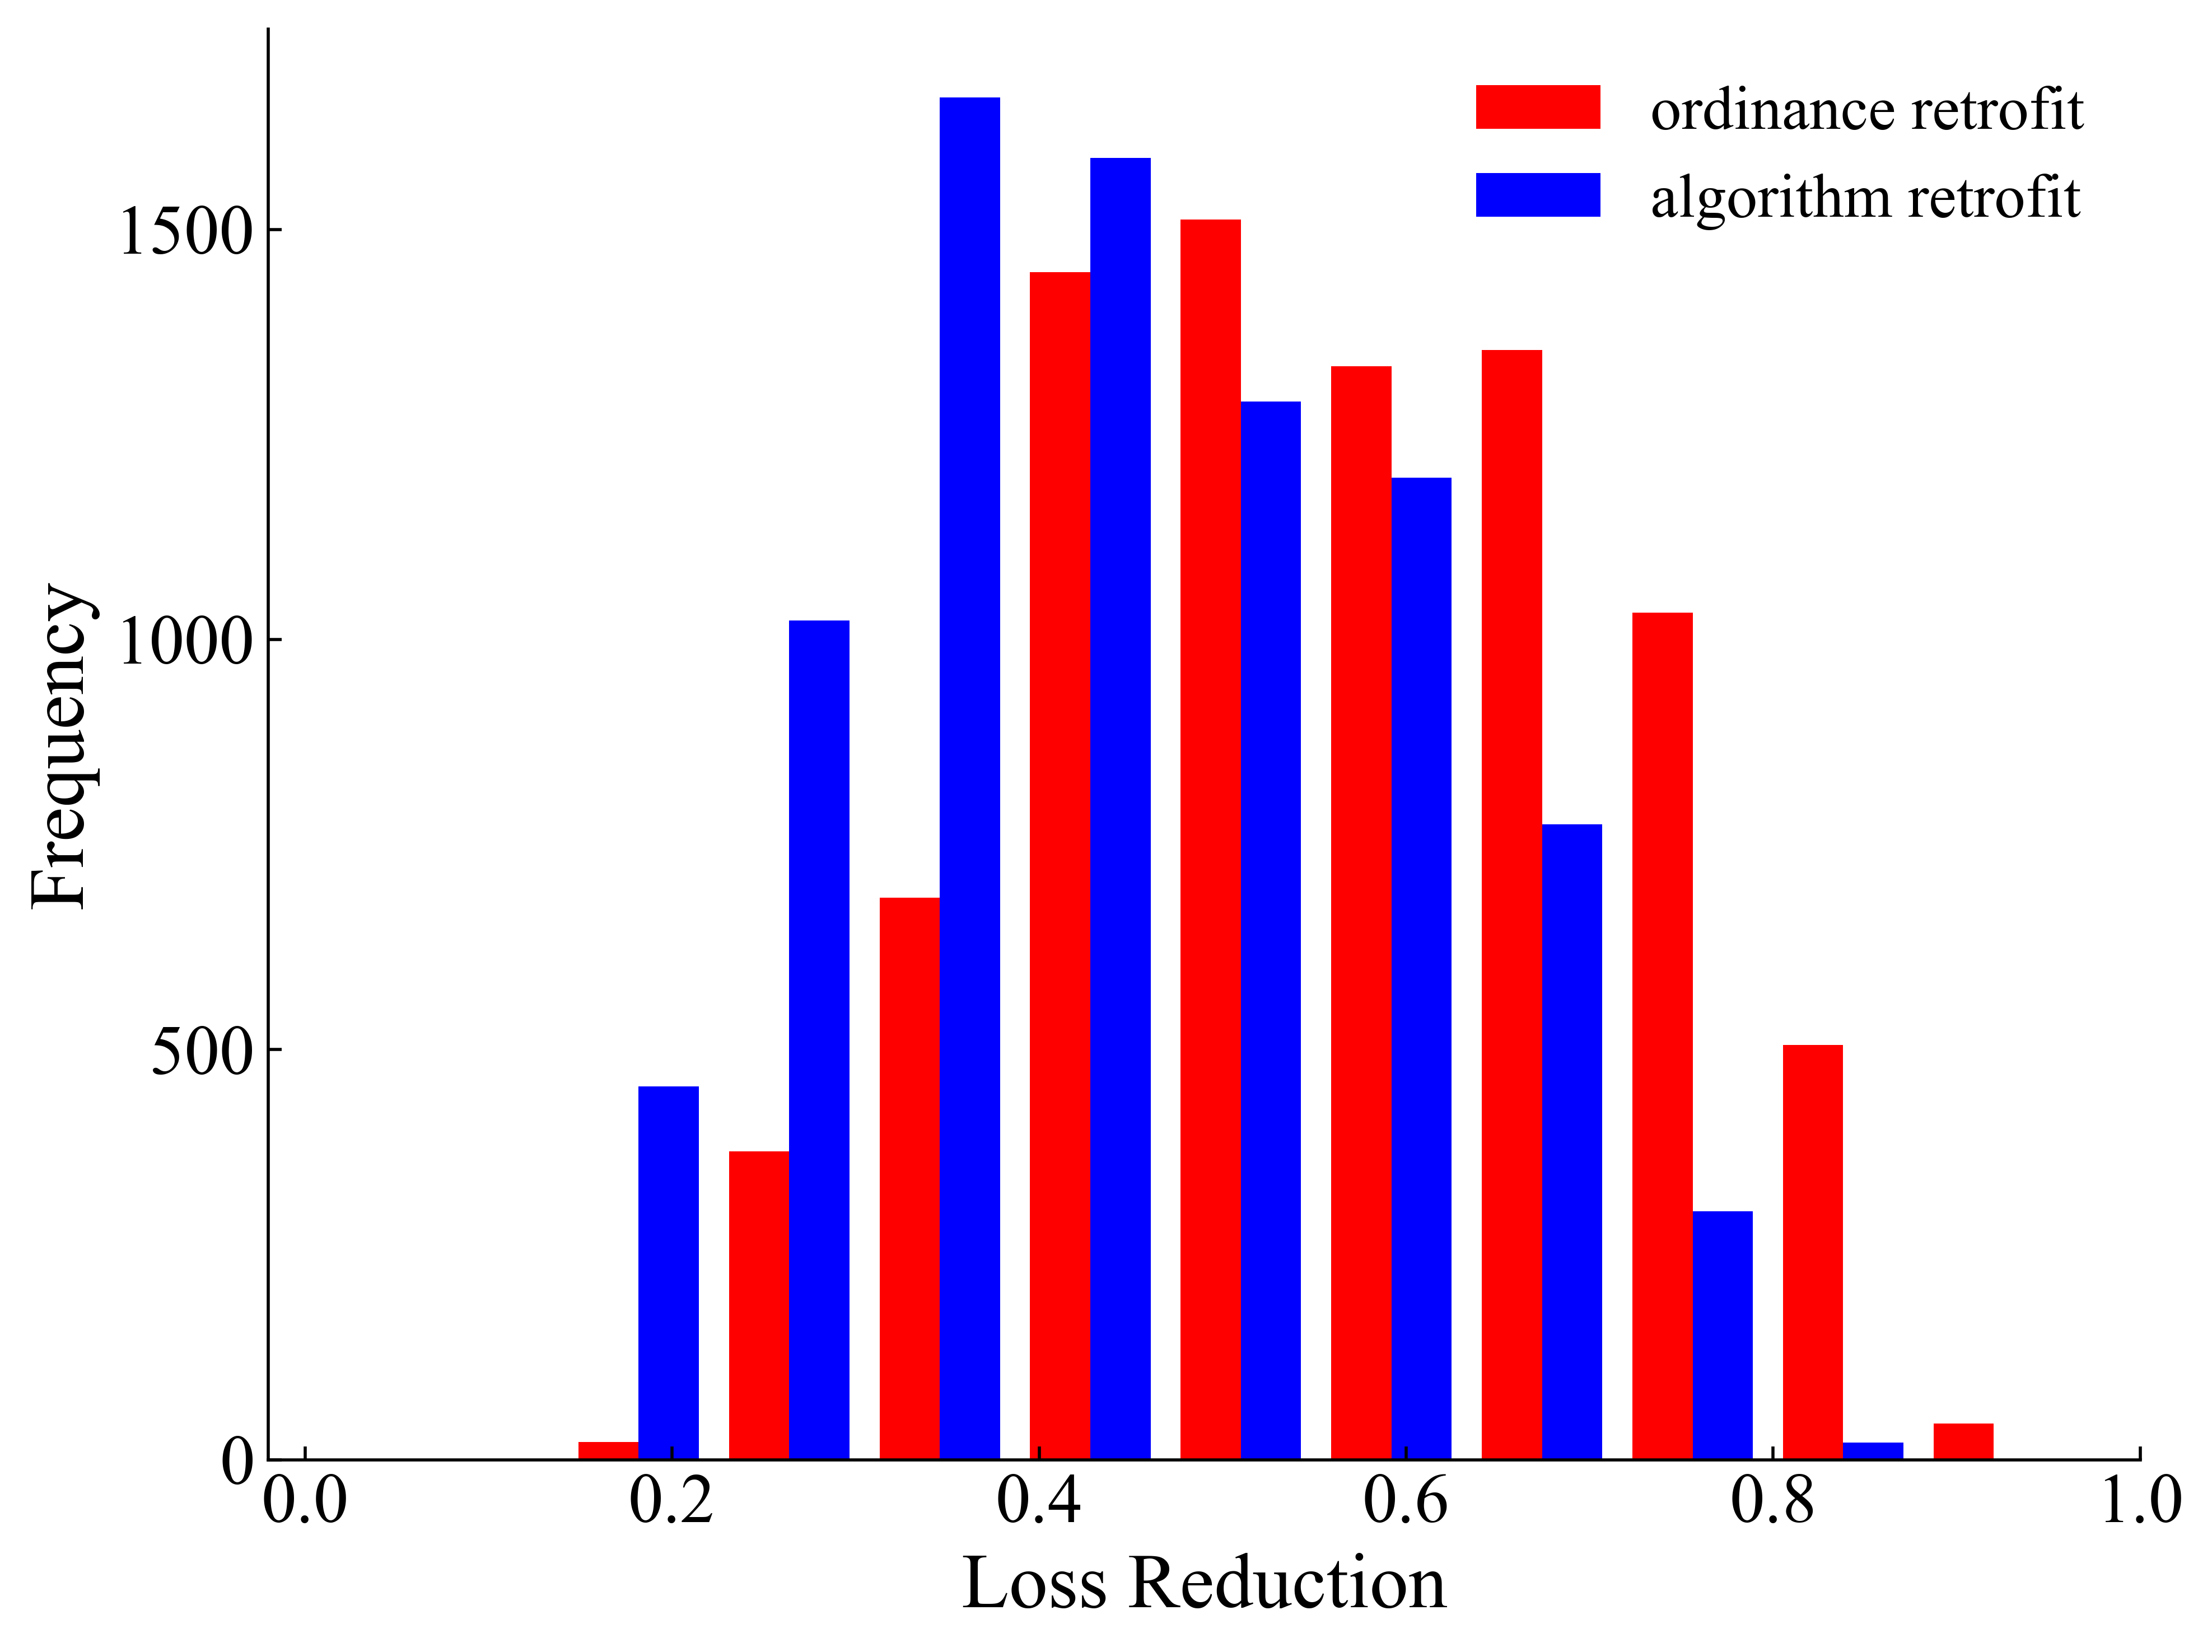

In [3]:
or_reduction = 1 - np.divide(r.iloc[:,1],r.iloc[:,0])
al_reduction = 1 - np.divide(r.iloc[:,2],r.iloc[:,0])

font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)

# plt.hist(or_reduction, label = 'ordinance retrofit', alpha=0.5, bins=20, color="red")
# plt.hist(al_reduction, label = 'algorithm retrofit', alpha=0.5, bins=20, color="blue")
plt.hist([or_reduction, al_reduction], color = ['red','blue'],   label=['ordinance retrofit', 'algorithm retrofit'])

ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks(fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)
plt.xlim([-0.02,1])
plt.xlabel('Loss Reduction', **font)
plt.ylabel('Frequency', **font)
plt.tight_layout()

plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":16})
sns.despine()

In [7]:
rate = pd.read_csv(r'D:\Google Drive\Research\Ph.D. Topic Research\Cost_Benefit\UCERF2_Event_Processed_Data\RateofExceedance.csv',header=None)
rate = rate.iloc[0:8312]

or_reduction = 1 - np.divide(r.iloc[:,1],r.iloc[:,0])
al_reduction = 1 - np.divide(r.iloc[:,2],r.iloc[:,0])

In [23]:
or_lembda, al_lembda = [], []
evaluated_loss_reduction = np.linspace(0, 1,100)
for i in range(100):
    threshold = evaluated_loss_reduction[i]
    or_lembda.append(np.multiply((or_reduction > threshold).values, rate.values.T[0]).sum())
    al_lembda.append(np.multiply((al_reduction > threshold).values, rate.values.T[0]).sum())

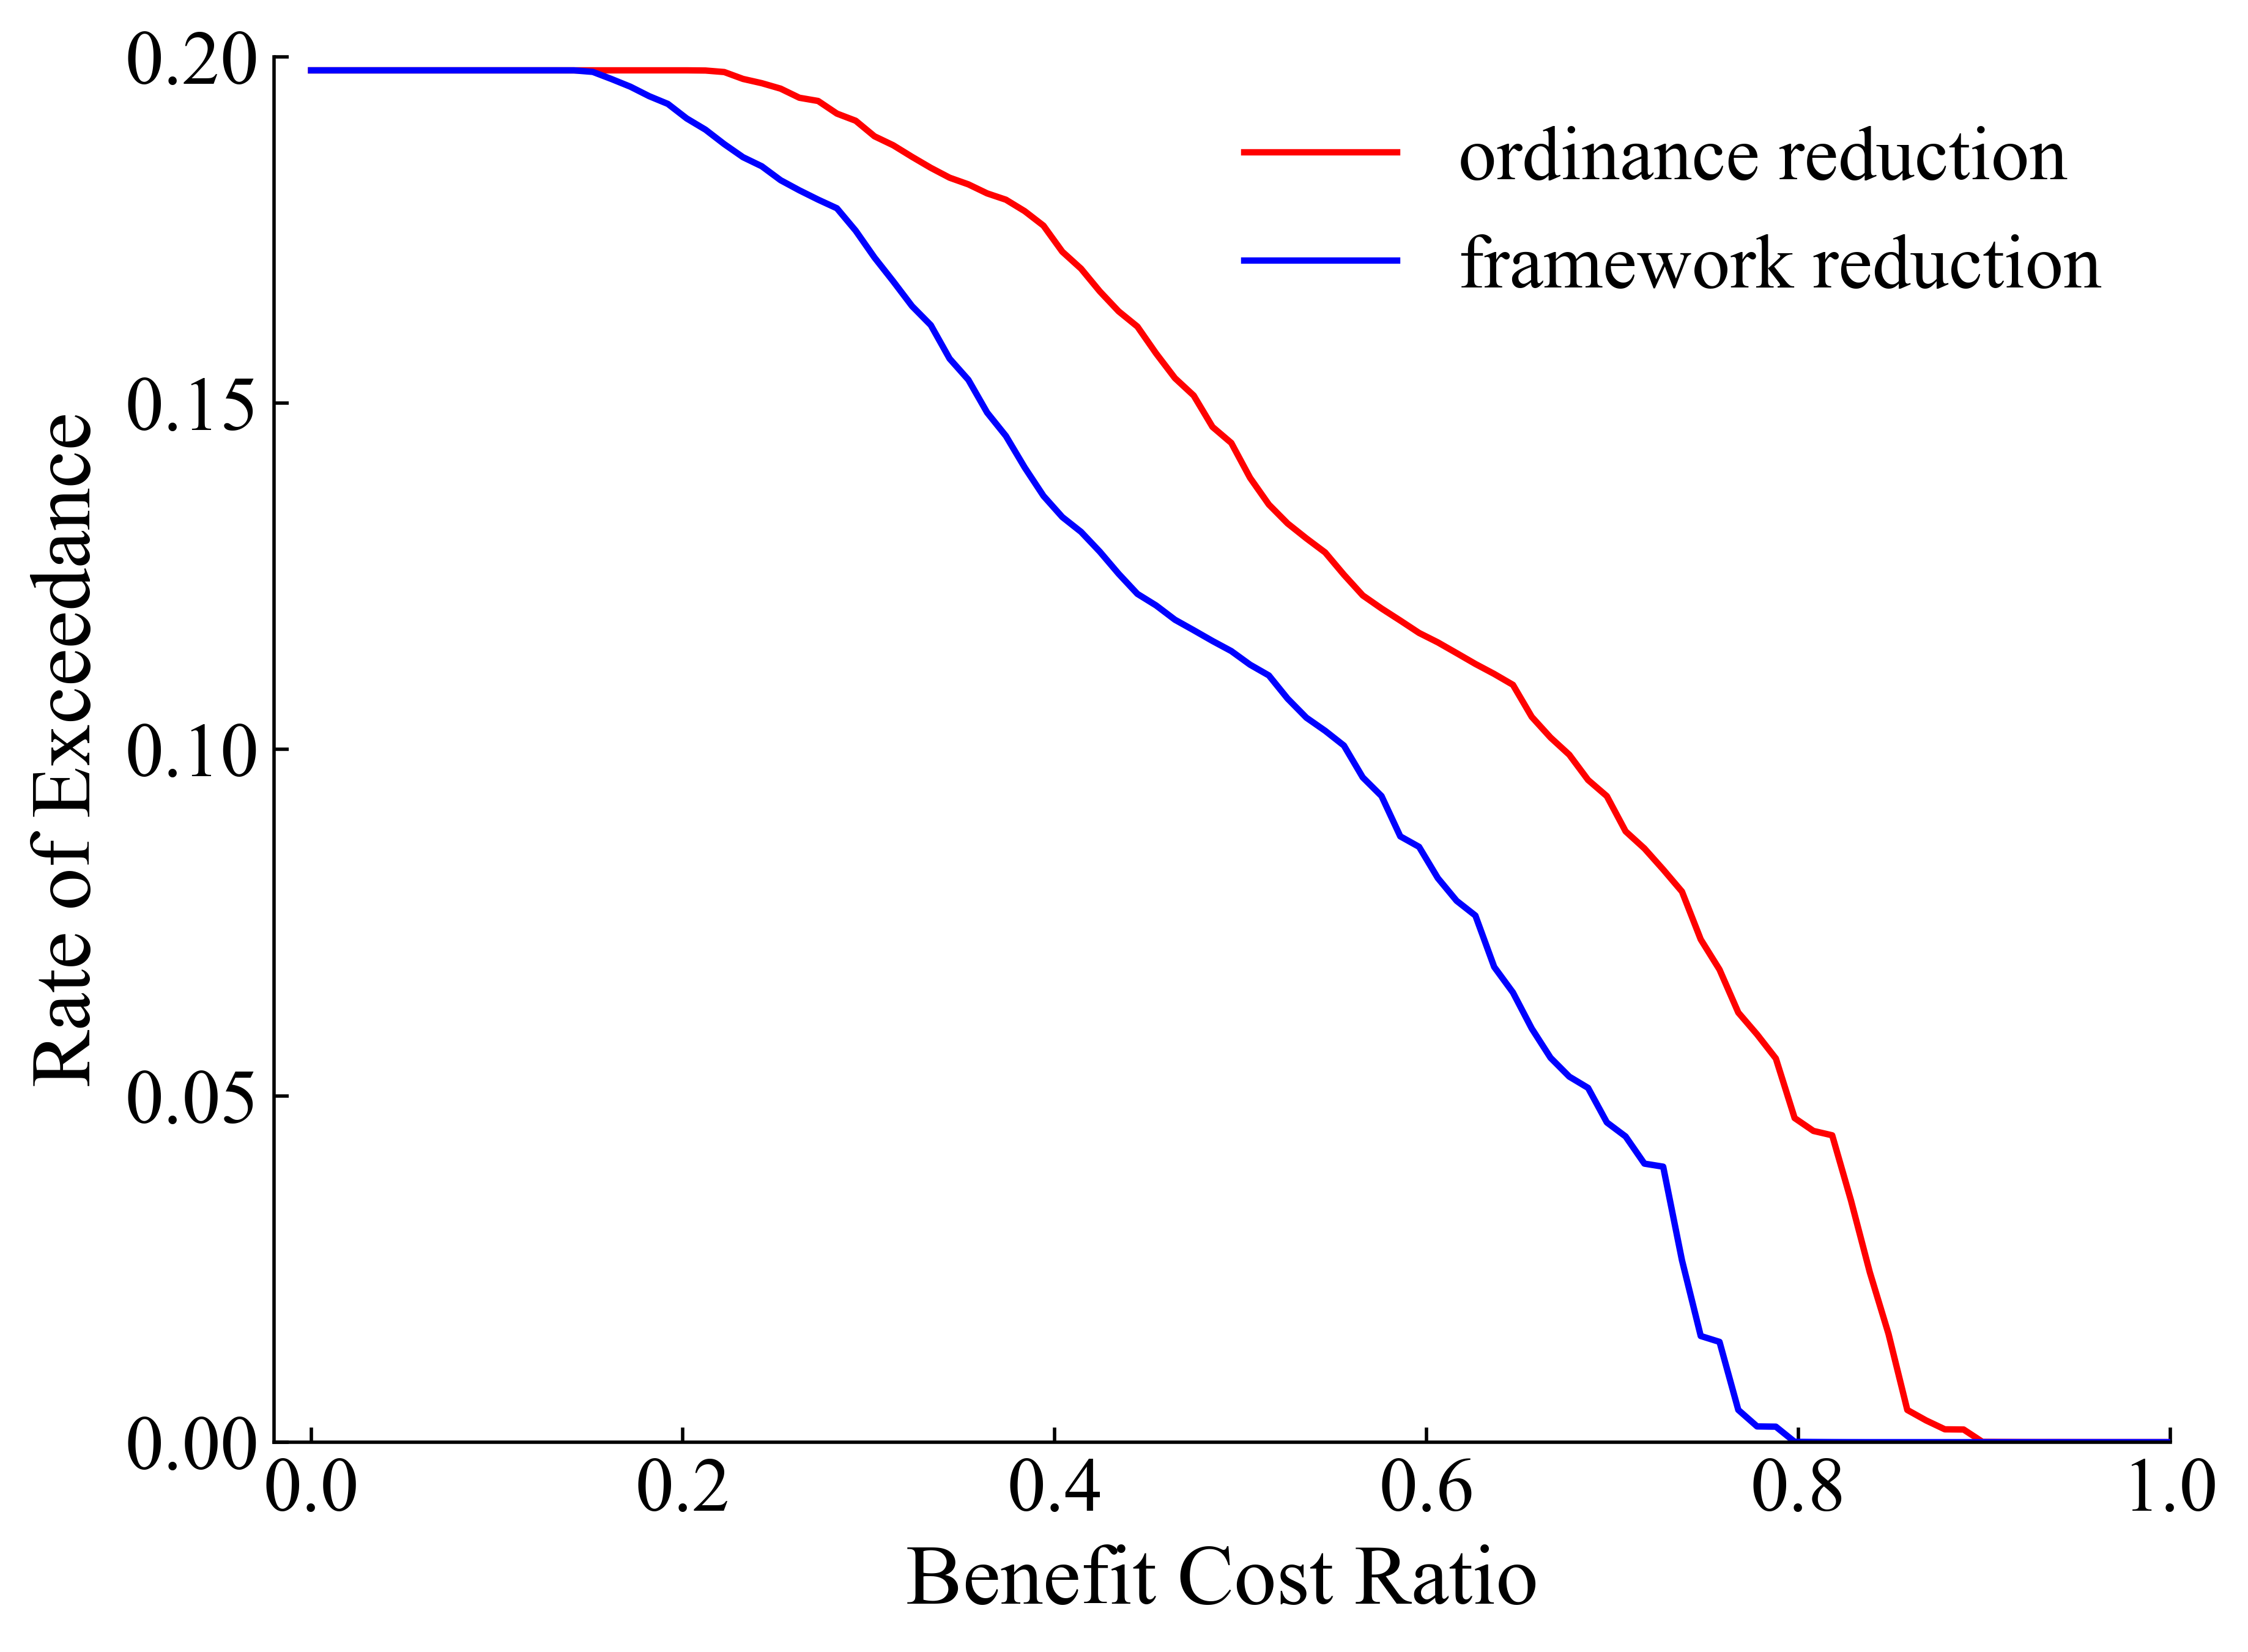

In [24]:
font = {'fontname':'Times New Roman', 'size' : 20}
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
ax.plot(evaluated_loss_reduction, or_lembda, label = 'ordinance reduction', color = 'red')
ax.plot(evaluated_loss_reduction, al_lembda, label = 'framework reduction', color = 'blue')

ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks(fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.xlim([-0.02,1])
plt.ylim([0,0.2])
plt.xlabel('Benefit Cost Ratio', **font)
plt.ylabel('Rate of Exceedance', **font)
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
sns.despine()

In [12]:
a1 = np.multiply((or_reduction > 0.5).values, rate.values.T[0]).sum()
a2 = np.multiply((al_reduction > 0.5).values, rate.values.T[0]).sum()
(1-np.exp(-a2*10)) - (1-np.exp(-a1*10))


-0.07718339221709225

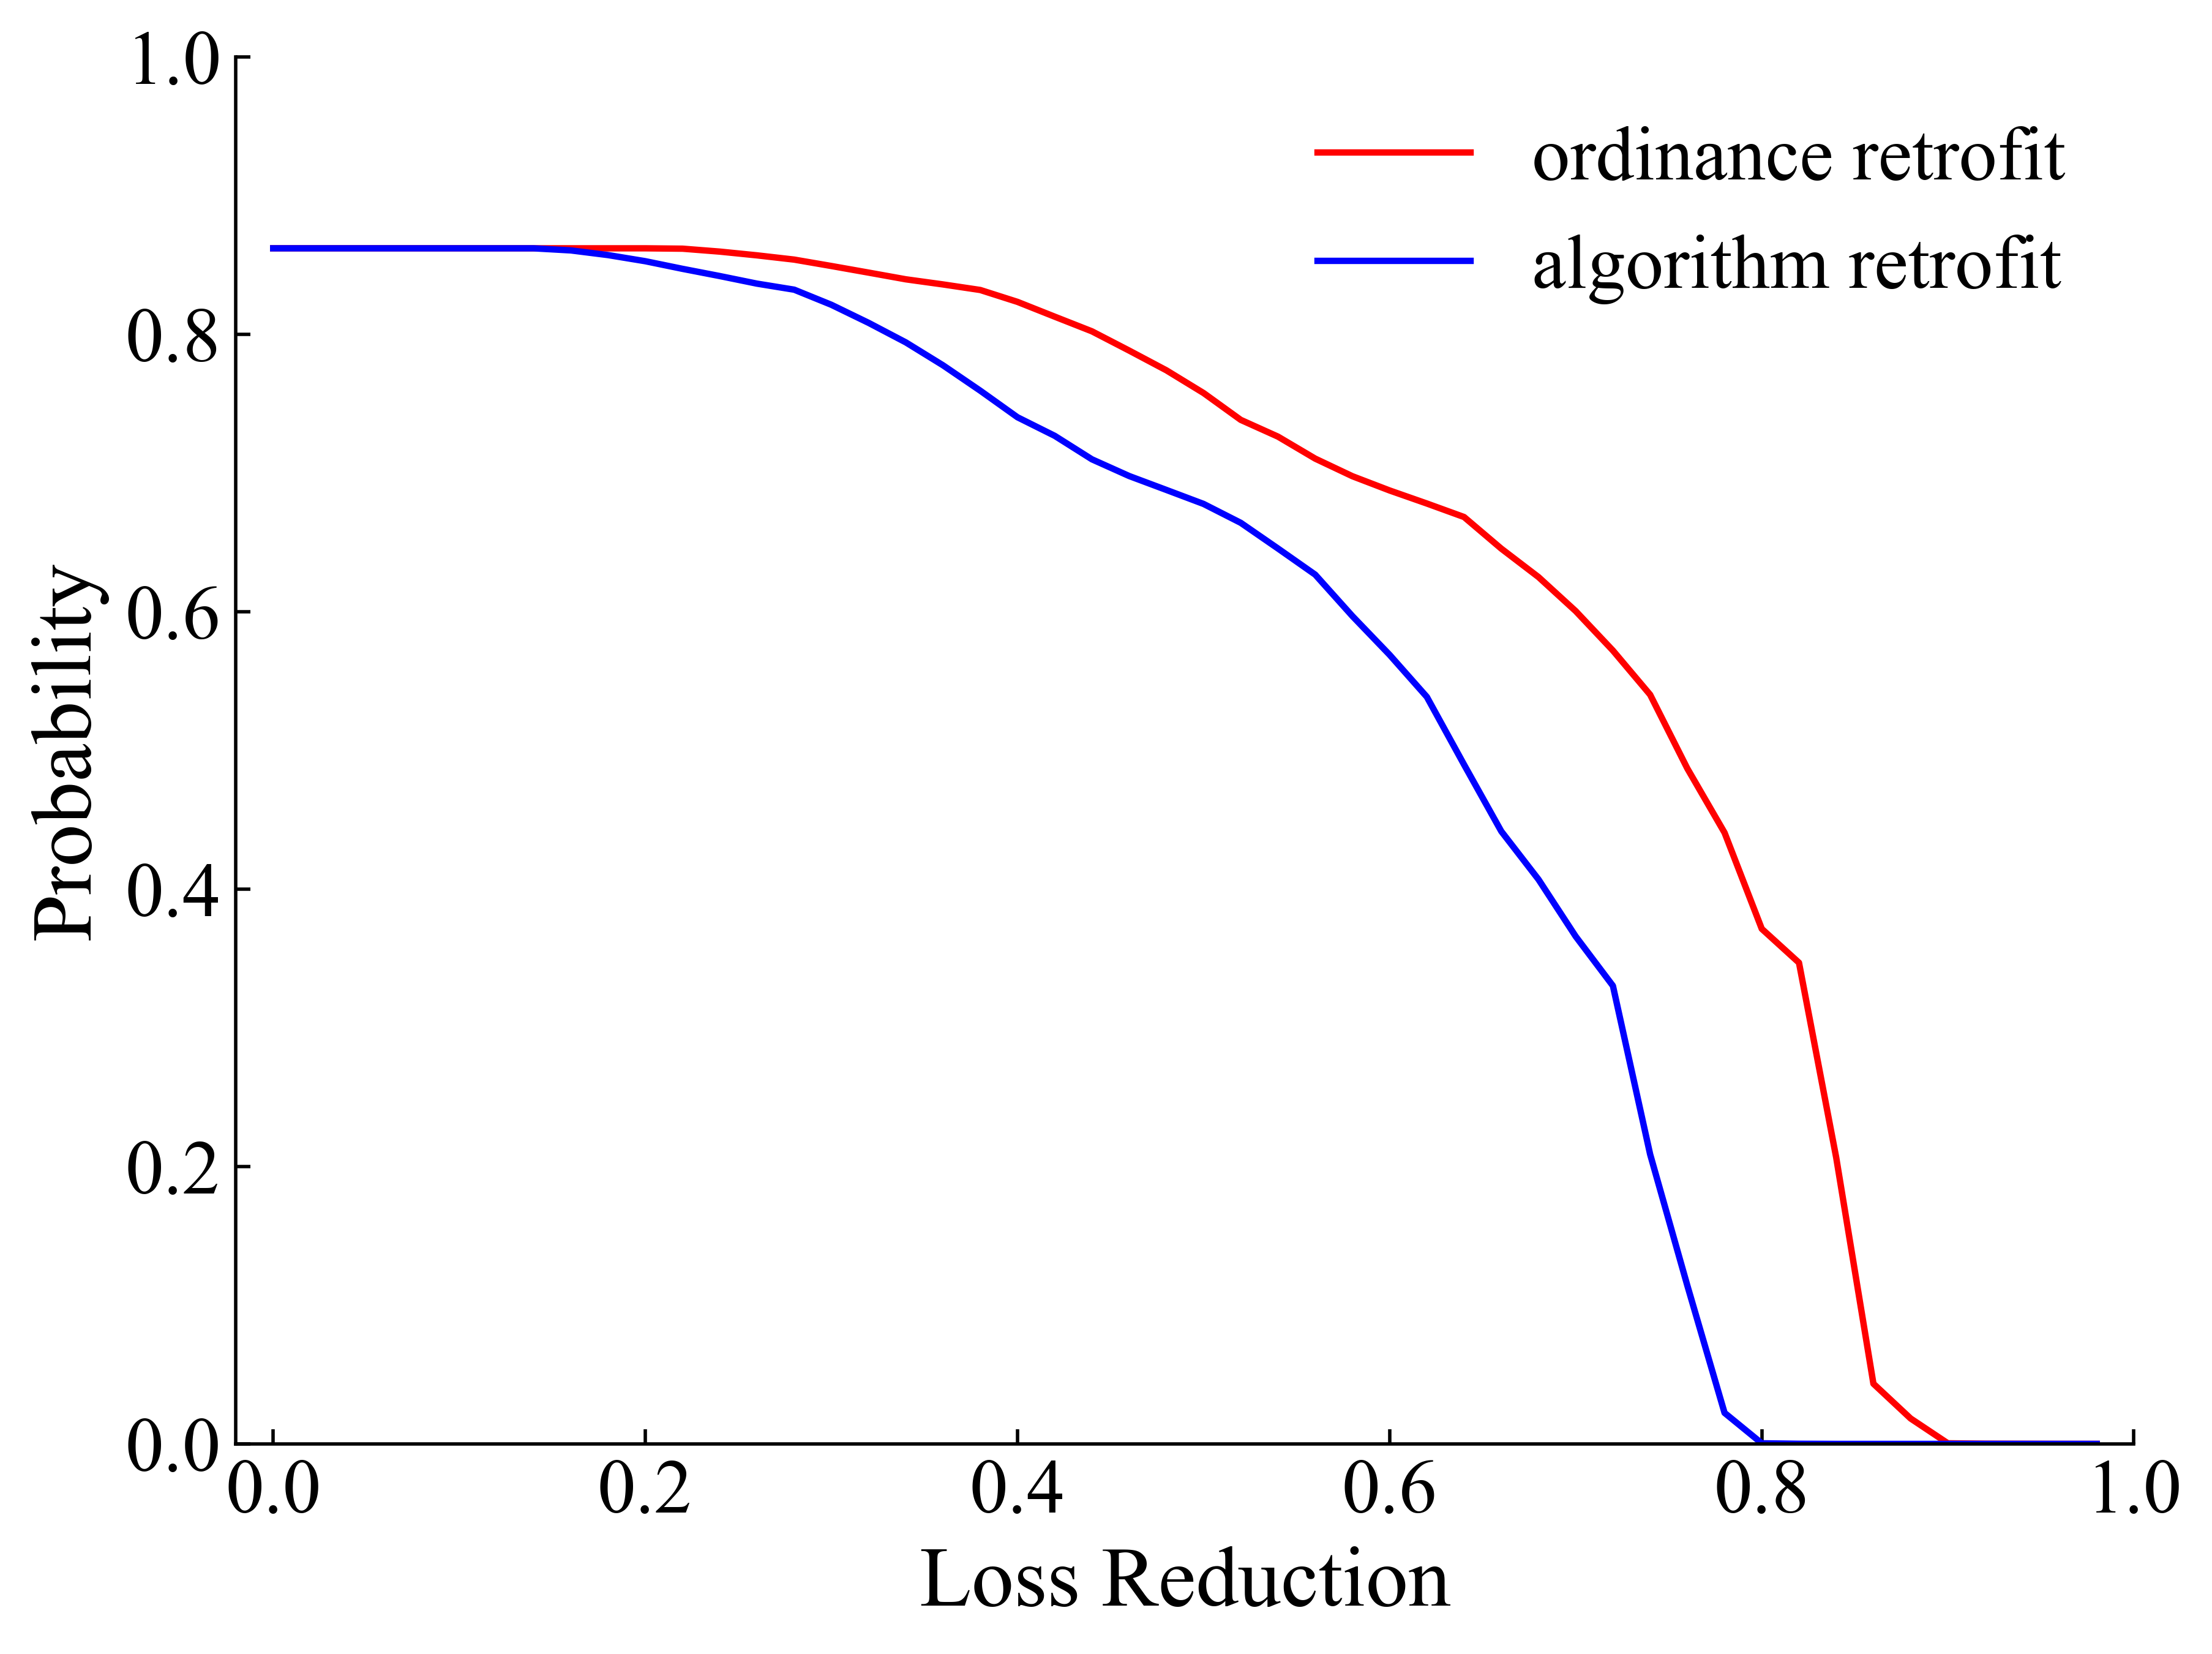

In [13]:
or_reduction_prop, al_reduction_prop = [], []
for i in range(50):
    l1 = np.interp(0.02*i,evaluated_loss_reduction,or_lembda )
    or_reduction_prop.append(1-np.exp(-l1*10))

    l2 = np.interp(0.02*i,evaluated_loss_reduction,al_lembda )
    al_reduction_prop.append(1-np.exp(-l2*10))

fig, ax = plt.subplots(figsize=(8,6), dpi=500)
plt.plot(np.multiply(0.02, range(50)), or_reduction_prop, label = 'ordinance retrofit', color = 'red')
plt.plot(np.multiply(0.02, range(50)), al_reduction_prop, label = 'algorithm retrofit', color = 'blue')
plt.xlabel('Loss Reduction', **font)
plt.ylabel('Probability', **font)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.xticks(fontname = 'Times New Roman', fontsize = 18)
plt.yticks(fontname = 'Times New Roman', fontsize = 18)
plt.locator_params(axis='y', nbins=6)
plt.xlim([-0.02,1])
plt.ylim([0,1])
plt.xlabel('Loss Reduction')
plt.legend(frameon = False, prop =  {"family":'Times New Roman', "size":18})
sns.despine()